In [2]:
import os

def move_to_parent_dir():
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    os.chdir(parent_directory)
    print("Working directory:", os.getcwd())

move_to_parent_dir() 

Working directory: c:\Users\benjo\OneDrive\Data Science Masters\DSMP\dsmp-2024-group-19


In [3]:
from tools import get_Tapes
raw_tapes = get_Tapes(125,0)
tapes_data = [t["Price"].resample("1min").last().ffill().to_numpy() for t in raw_tapes] # resample down to 1 min

Opening UoB_Set01_2025-01-02tapes.csv
Opening UoB_Set01_2025-01-03tapes.csv
Opening UoB_Set01_2025-01-06tapes.csv
Opening UoB_Set01_2025-01-07tapes.csv
Opening UoB_Set01_2025-01-08tapes.csv
Opening UoB_Set01_2025-01-09tapes.csv
Opening UoB_Set01_2025-01-10tapes.csv
Opening UoB_Set01_2025-01-13tapes.csv
Opening UoB_Set01_2025-01-14tapes.csv
Opening UoB_Set01_2025-01-15tapes.csv
Opening UoB_Set01_2025-01-16tapes.csv
Opening UoB_Set01_2025-01-17tapes.csv
Opening UoB_Set01_2025-01-20tapes.csv
Opening UoB_Set01_2025-01-21tapes.csv
Opening UoB_Set01_2025-01-22tapes.csv
Opening UoB_Set01_2025-01-23tapes.csv
Opening UoB_Set01_2025-01-24tapes.csv
Opening UoB_Set01_2025-01-27tapes.csv
Opening UoB_Set01_2025-01-28tapes.csv
Opening UoB_Set01_2025-01-29tapes.csv
Opening UoB_Set01_2025-01-30tapes.csv
Opening UoB_Set01_2025-01-31tapes.csv
Opening UoB_Set01_2025-02-03tapes.csv
Opening UoB_Set01_2025-02-04tapes.csv
Opening UoB_Set01_2025-02-05tapes.csv
Opening UoB_Set01_2025-02-06tapes.csv
Opening UoB_

In [4]:
# get test data
import matplotlib.pyplot as plt
import numpy as np
from numba import njit


# define broker

def broker(actor, price_data: np.array, starting_cash: int):
    time_index = 0
    final_time_index = price_data.shape[0]
    num_stocks = np.zeros_like(price_data)
    cash_value = np.zeros_like(price_data)
    cash_value[0] = starting_cash

    while True:
        action = actor(price_data[:time_index], cash_value[time_index], num_stocks[time_index])

        while abs(action) > 0:
            if action > 0: # buy  stock
                if cash_value[time_index] >= price_data[time_index]:
                    cash_value[time_index] = cash_value[time_index] - price_data[time_index]
                    num_stocks[time_index] = num_stocks[time_index] + 1

                action += -1

            else: # sell one stock
                if num_stocks[time_index] > 0:
                    num_stocks[time_index] = num_stocks[time_index] - 1
                    cash_value[time_index] = cash_value[time_index] + price_data[time_index]

                action += 1

        time_index += 1
        if time_index >= final_time_index:
            break

        num_stocks[time_index] = num_stocks[time_index - 1]
        cash_value[time_index] = cash_value[time_index - 1]

    total_value = num_stocks * price_data + cash_value
    profit = (total_value[-1] / starting_cash) - 1
    
    return num_stocks, cash_value, total_value, profit

# generate folds
def generate_folds(tapes_data, n_folds=5):
    tapes_data = np.array(tapes_data)
    fold_size = len(tapes_data) // n_folds
    
    for i in range(n_folds):
        start_index = i * fold_size
        end_index = (i + 1) * fold_size if i < n_folds - 1 else len(tapes_data)
        
        test_indices = np.arange(start_index,end_index,1, dtype=int)
        # Test split
        test_data = tapes_data[test_indices]
        
        # Training split
        train_data = np.delete(tapes_data, test_indices, axis=0)
        
        yield train_data, test_data

def display_results(results, data):
    # Plotting Actor vs. Data
    plt.figure(figsize=(20, 6))
    plt.plot(results[2], color='red', label="Actor's Performance")
    plt.legend(loc='upper right')
    plt.twinx()
    plt.plot(data, color='blue', label="Market Data", alpha=0.7)
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.title("Actor Performance vs. Market Data")
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # Plotting Stocks Held and Cash Held
    plt.figure(figsize=(20, 6))
    plt.plot(results[0], color='orange', label="Stocks Held")
    plt.legend(loc='upper right')
    plt.twinx()
    plt.plot(results[1], color='green', label="Cash Held")
    plt.xlabel("Time")
    plt.ylabel("Amount")
    plt.title("Portfolio Holdings Over Time")
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Example

In [5]:
cash = 10_000

@njit
def random_actor(current_data, current_cash, current_stocks):
    return np.random.randint(-10,11)


results = broker(random_actor, tapes_data[100], cash)
results[-1]

0.040200000000000014

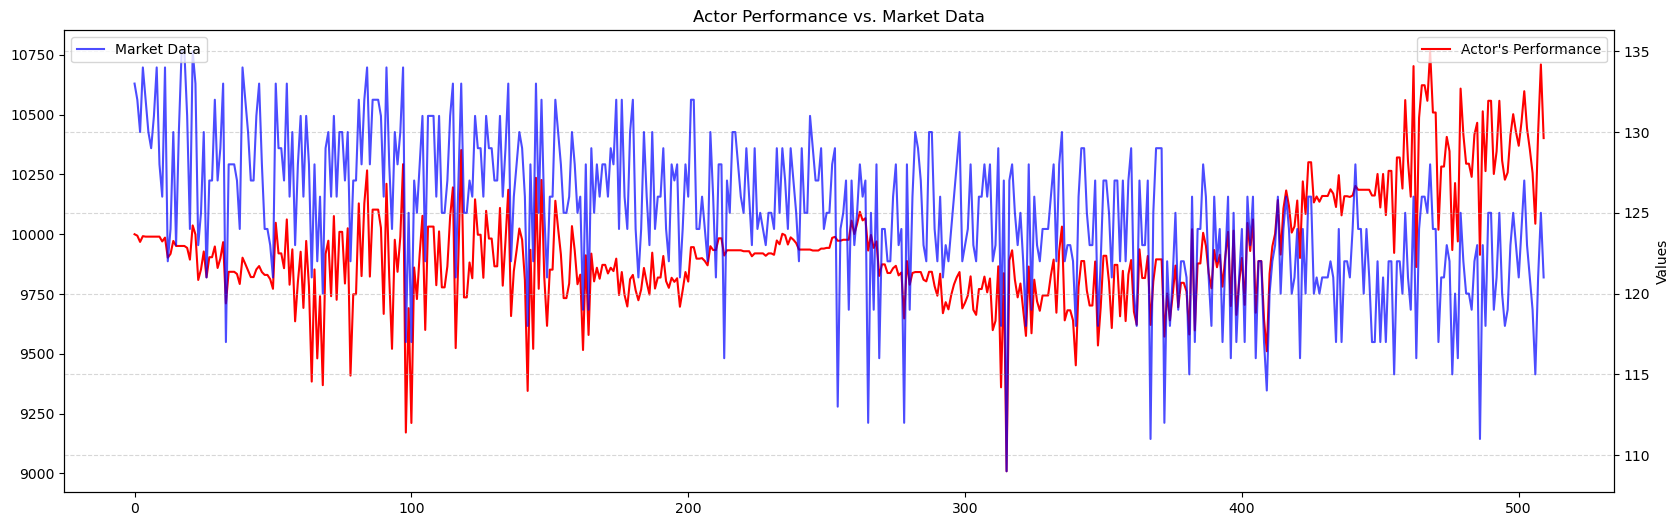

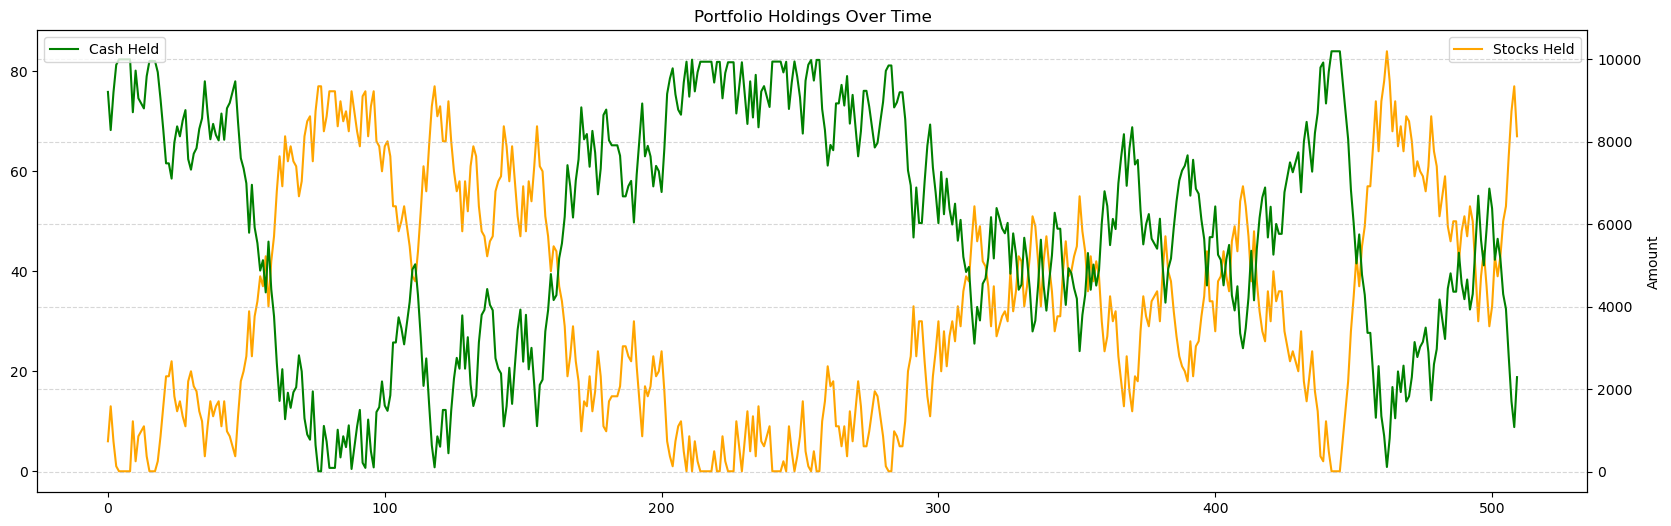

In [6]:
display_results(results, tapes_data[100])

# MA investigation

In [7]:
def MA_actor(current_data, current_cash, current_stocks):
    if len(current_data) == 0:
        return 0

    window = 2
    ma = np.mean(current_data[-window:])

    return int(current_data[-1] - ma)

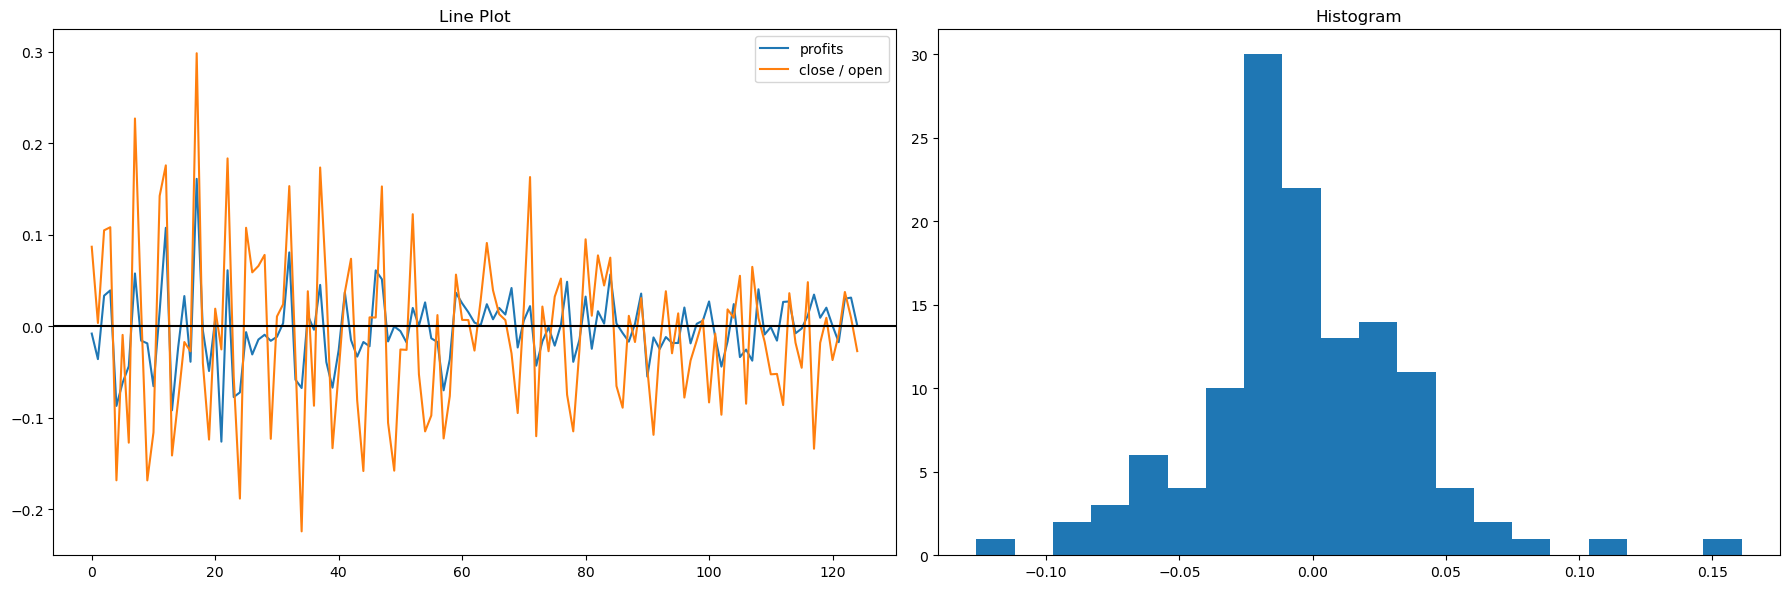

0.004303884847979254


In [8]:
profits = []
open_vs_close = []

for data in tapes_data:
    results = broker(MA_actor, data, cash)
    profits.append(results[-1])
    open_vs_close.append(data[-1] / data[1] - 1)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot line plot on the first subplot
axs[0].plot(profits, label = "profits")
axs[0].plot(open_vs_close, label = "close / open")
axs[0].set_title('Line Plot')
axs[0].axhline(0, color = "black")
axs[0].legend()

# Plot histogram on the second subplot
axs[1].hist(profits, bins=20)  # You can adjust the number of bins as needed
axs[1].set_title('Histogram')

# Show the plot
plt.tight_layout()
plt.show()

print(np.mean(np.array(profits) - np.array(open_vs_close)))

In [19]:
from statsmodels.tsa.arima.model import ARIMA
cv_scores = []
for train_data, test_data in generate_folds(tapes_data):
    # train model on training data
    coeffs = []
    for train in train_data:    
        model = ARIMA(train, order=(1, 0, 1))
        model_fit = model.fit()
        coeffs.append(model_fit.params)

    model_coeffs = np.mean(coeffs, axis=0)
    print(model_coeffs)

    for test in test_data:
        # appply model to test data
        model = ARIMA(test, order=(1, 0, 1))
        model_fit = model.fit_constrained({'ar.L1': model_coeffs[1], 'ma.L1': model_coeffs[2]})
        #print(model_fit.summary()) 


c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[176.50728066   0.77977534  -0.70054618  16.35092968]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1886.473
Date:                Tue, 26 Mar 2024   AIC                           3776.946
Time:                        17:15:30   BIC                           3785.415
Sample:                             0   HQIC                          3780.266
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           281.2601      0.699    402.491      0.000     279.890     282.630
ar.L1 (fixed)     0.7798        nan        nan        nan         na

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2047.857
Date:                Tue, 26 Mar 2024   AIC                           4099.715
Time:                        17:15:31   BIC                           4108.184
Sample:                             0   HQIC                          4103.035
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           314.1275      0.804    390.632      0.000     312.551     315.704
ar.L1 (fixed)     0.7798        nan        nan        nan         nan         nan
ma.L1 (fixed)    -0.7005        nan     

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1985.663
Date:                Tue, 26 Mar 2024   AIC                           3975.326
Time:                        17:15:32   BIC                           3983.795
Sample:                             0   HQIC                          3978.646
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           363.5681      0.764    475.839      0.000     362.071     365.066
ar.L1 (fixed)     0.7798        nan        nan        nan         nan         nan
ma.L1 (fixed)    -0.7005        nan     

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[188.07774154   0.78066448  -0.68823842  17.14921445]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1779.685
Date:                Tue, 26 Mar 2024   AIC                           3563.371
Time:                        17:16:00   BIC                           3571.839
Sample:                             0   HQIC                          3566.691
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           293.7763      0.533    551.514      0.000     292.732     294.820
ar.L1 (fixed)     0.7807        nan        nan        nan         na

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1777.613
Date:                Tue, 26 Mar 2024   AIC                           3559.226
Time:                        17:16:00   BIC                           3567.695
Sample:                             0   HQIC                          3562.546
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           319.4456      0.511    624.816      0.000     318.444     320.448
ar.L1 (fixed)     0.7807        nan        nan        nan         nan         nan
ma.L1 (fixed)    -0.6882        nan     

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1710.233
Date:                Tue, 26 Mar 2024   AIC                           3424.466
Time:                        17:16:00   BIC                           3432.934
Sample:                             0   HQIC                          3427.786
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           321.2872      0.432    744.033      0.000     320.441     322.134
ar.L1 (fixed)     0.7807        nan        nan        nan         nan         nan
ma.L1 (fixed)    -0.6882        nan     

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1996.389
Date:                Tue, 26 Mar 2024   AIC                           3996.777
Time:                        17:16:01   BIC                           4005.246
Sample:                             0   HQIC                          4000.098
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           280.9747      0.805    349.135      0.000     279.397     282.552
ar.L1 (fixed)     0.7807        nan        nan        nan         nan         nan
ma.L1 (fixed)    -0.6882        nan     

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1895.506
Date:                Tue, 26 Mar 2024   AIC                           3795.013
Time:                        17:16:02   BIC                           3803.482
Sample:                             0   HQIC                          3798.333
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           234.5753      0.638    367.755      0.000     233.325     235.825
ar.L1 (fixed)     0.7807        nan        nan        nan         nan         nan
ma.L1 (fixed)    -0.6882        nan     

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1704.658
Date:                Tue, 26 Mar 2024   AIC                           3413.317
Time:                        17:16:02   BIC                           3421.786
Sample:                             0   HQIC                          3416.637
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           217.1249      0.429    506.139      0.000     216.284     217.966
ar.L1 (fixed)     0.7807        nan        nan        nan         nan         nan
ma.L1 (fixed)    -0.6882        nan     

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1790.913
Date:                Tue, 26 Mar 2024   AIC                           3585.827
Time:                        17:16:02   BIC                           3594.296
Sample:                             0   HQIC                          3589.147
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           213.1583      0.548    389.228      0.000     212.085     214.232
ar.L1 (fixed)     0.7807        nan        nan        nan         nan         nan
ma.L1 (fixed)    -0.6882        nan     

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[216.41346707   0.78507509  -0.66900819  18.8826511 ]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1406.097
Date:                Tue, 26 Mar 2024   AIC                           2816.195
Time:                        17:16:32   BIC                           2824.664
Sample:                             0   HQIC                          2819.515
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           190.0592      0.298    638.555      0.000     189.476     190.643
ar.L1 (fixed)     0.7851        nan        nan        nan         na

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1519.913
Date:                Tue, 26 Mar 2024   AIC                           3043.826
Time:                        17:16:32   BIC                           3052.295
Sample:                             0   HQIC                          3047.147
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           170.2765      0.343    496.133      0.000     169.604     170.949
ar.L1 (fixed)     0.7851        nan        nan        nan         nan         nan
ma.L1 (fixed)    -0.6690        nan     

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1380.581
Date:                Tue, 26 Mar 2024   AIC                           2765.162
Time:                        17:16:33   BIC                           2773.631
Sample:                             0   HQIC                          2768.483
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           146.1523      0.275    532.031      0.000     145.614     146.691
ar.L1 (fixed)     0.7851        nan        nan        nan         nan         nan
ma.L1 (fixed)    -0.6690        nan     

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1416.434
Date:                Tue, 26 Mar 2024   AIC                           2836.867
Time:                        17:16:33   BIC                           2845.336
Sample:                             0   HQIC                          2840.188
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           141.5839      0.297    476.686      0.000     141.002     142.166
ar.L1 (fixed)     0.7851        nan        nan        nan         nan         nan
ma.L1 (fixed)    -0.6690        nan     

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1519.121
Date:                Tue, 26 Mar 2024   AIC                           3042.242
Time:                        17:16:34   BIC                           3050.711
Sample:                             0   HQIC                          3045.562
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           156.6569      0.329    476.885      0.000     156.013     157.301
ar.L1 (fixed)     0.7851        nan        nan        nan         nan         nan
ma.L1 (fixed)    -0.6690        nan     

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1478.918
Date:                Tue, 26 Mar 2024   AIC                           2961.836
Time:                        17:16:34   BIC                           2970.305
Sample:                             0   HQIC                          2965.156
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           143.6116      0.299    480.876      0.000     143.026     144.197
ar.L1 (fixed)     0.7851        nan        nan        nan         nan         nan
ma.L1 (fixed)    -0.6690        nan     

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[215.64129084   0.78506831  -0.66896581  18.76687326]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1486.744
Date:                Tue, 26 Mar 2024   AIC                           2977.489
Time:                        17:17:07   BIC                           2985.958
Sample:                             0   HQIC                          2980.809
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           157.2677      0.345    455.526      0.000     156.591     157.944
ar.L1 (fixed)     0.7851        nan        nan        nan         na

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1506.862
Date:                Tue, 26 Mar 2024   AIC                           3017.725
Time:                        17:17:07   BIC                           3026.194
Sample:                             0   HQIC                          3021.045
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           175.4187      0.350    500.953      0.000     174.732     176.105
ar.L1 (fixed)     0.7851        nan        nan        nan         nan         nan
ma.L1 (fixed)    -0.6690        nan     

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1451.874
Date:                Tue, 26 Mar 2024   AIC                           2907.748
Time:                        17:17:07   BIC                           2916.216
Sample:                             0   HQIC                          2911.068
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           158.8718      0.287    552.888      0.000     158.309     159.435
ar.L1 (fixed)     0.7851        nan        nan        nan         nan         nan
ma.L1 (fixed)    -0.6690        nan     

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1509.873
Date:                Tue, 26 Mar 2024   AIC                           3023.747
Time:                        17:17:08   BIC                           3032.216
Sample:                             0   HQIC                          3027.067
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           187.3365      0.336    556.736      0.000     186.677     187.996
ar.L1 (fixed)     0.7851        nan        nan        nan         nan         nan
ma.L1 (fixed)    -0.6690        nan     

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1505.089
Date:                Tue, 26 Mar 2024   AIC                           3014.177
Time:                        17:17:09   BIC                           3022.646
Sample:                             0   HQIC                          3017.498
                                - 510                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           134.6445      0.317    424.713      0.000     134.023     135.266
ar.L1 (fixed)     0.7851        nan        nan        nan         nan         nan
ma.L1 (fixed)    -0.6690        nan     

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


KeyboardInterrupt: 